# Simple Linear Regression : 1 variable

Simple linear regression with 1 variable

The data : Gender, Height (inch), weight (lbs)

In [1]:
!wget https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv

--2024-05-31 11:14:51--  https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418120 (408K) [text/plain]
Saving to: ‘weight-height.csv’

weight-height.csv   100%[===================>] 408.32K  --.-KB/s    in 0.02s   

2024-05-31 11:14:51 (16.1 MB/s) - ‘weight-height.csv’ saved [418120/418120]



##Instal package

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d7bad2062054bd1923322c8bd6b2cdecedcd271015b8674c07254dd6827c58da
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MlLib - Machine Learning').getOrCreate()

##Loading data

In [4]:
df = spark.read.csv(path='weight-height.csv', sep=',', header = True, inferSchema = True)

##Eksplorasi

In [5]:
df.printSchema()
df.show(5)
df.describe().show()

root
 |-- Gender: string (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)

+------+----------------+----------------+
|Gender|          Height|          Weight|
+------+----------------+----------------+
|  Male| 73.847017017515|241.893563180437|
|  Male|68.7819040458903|  162.3104725213|
|  Male|74.1101053917849|  212.7408555565|
|  Male|71.7309784033377|220.042470303077|
|  Male|69.8817958611153|206.349800623871|
+------+----------------+----------------+
only showing top 5 rows

+-------+------+-----------------+------------------+
|summary|Gender|           Height|            Weight|
+-------+------+-----------------+------------------+
|  count| 10000|            10000|             10000|
|   mean|  NULL|66.36755975482106|161.44035683283076|
| stddev|  NULL|3.847528120773333|32.108439006519674|
|    min|Female| 54.2631333250971|   64.700126712753|
|    max|  Male| 78.9987423463896|  269.989698505106|
+-------+------+-----------------+--

First we plot the data with `scatterplot`. Since the data is quite big, we will sample 100 data point randomly using dataframe's `sample` function.

<Axes: xlabel='Weight', ylabel='Height'>

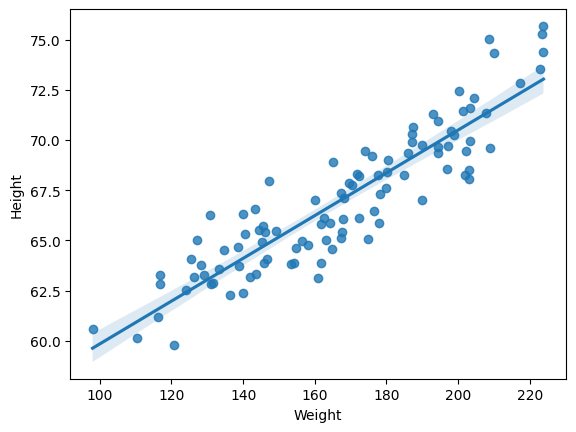

In [6]:
import seaborn as sns
import pandas as pd

sample = df.sample(fraction=.01)
pdf = sample.toPandas()

sns.regplot(x='Weight', y='Height', data=pdf)
#sns.scatterplot(x='Weight', y='Height', data=pdf)

In [7]:
df_selected = df.select(["Weight", "Height"])
df_selected.show(5)

+----------------+----------------+
|          Weight|          Height|
+----------------+----------------+
|241.893563180437| 73.847017017515|
|  162.3104725213|68.7819040458903|
|  212.7408555565|74.1101053917849|
|220.042470303077|71.7309784033377|
|206.349800623871|69.8817958611153|
+----------------+----------------+
only showing top 5 rows



## Split Data

In [8]:
from pyspark.sql.functions import col

features = ['Weight']
label = 'Height'

df_selected = df.select(*features, col(label).alias("label"))
(training, test) = df_selected.randomSplit([.7, .3])

## Prepare data

In [9]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=features, outputCol="features")
training = vectorAssembler.transform(training)
training.show(5, False)

+----------------+----------------+------------------+
|Weight          |label           |features          |
+----------------+----------------+------------------+
|68.9825300912419|55.6682021205121|[68.9825300912419]|
|71.393748738973 |54.6168578301035|[71.393748738973] |
|72.7501446905149|57.353092760465 |[72.7501446905149]|
|77.5237739030693|58.2116499335358|[77.5237739030693]|
|78.6066703120237|54.8737275315254|[78.6066703120237]|
+----------------+----------------+------------------+
only showing top 5 rows



## Train Model

In [10]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.10131123288629132]
Intercept: 50.00434769942381
numIterations: 2
objectiveHistory: [0.4999999999999716, 0.4205062343626949, 0.13435147683666593]
+--------------------+
|           residuals|
+--------------------+
| -1.3248507500711213|
| -2.6204785744397725|
|-0.02166179021095...|
| 0.35327312199394356|
| -3.0943588502957695|
+--------------------+
only showing top 5 rows

RMSE: 1.489010
r2: 0.848902


## Evaluate Model

In [11]:
#prediction
test = vectorAssembler.transform(test)
predictions = lrModel.transform(test)

# Select example rows to display.
print("\nModel Prediction Result :  ")
predictions.select("features","label","prediction").show(5)


Model Prediction Result :  
+------------------+----------------+------------------+
|          features|           label|        prediction|
+------------------+----------------+------------------+
| [64.700126712753]|54.2631333250971| 56.55919730459209|
|[77.8985592718359]|56.1672991862273|57.896346779319344|
|[79.1743758333647]|56.7644564465812| 58.02560132810458|
|[80.5312593808895]| 56.108902096181| 58.16306887318744|
|[83.0268025400783]|57.8309190849284|58.415895427365804|
+------------------+----------------+------------------+
only showing top 5 rows



In [12]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select (prediction, true label) and compute test error
evaluator1 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")
rmse1 = evaluator1.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse1)

evaluator2 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="r2")
r21 = evaluator2.evaluate(predictions)
print("R-Squared on test data = %g" % r21)


Root Mean Squared Error (RMSE) on test data = 1.51063
R-Squared on test data = 0.848787
